In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Embedding

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers import Input, Reshape, Dropout
from keras import Model

# from keras.utils import plot_model
from keras.layers import RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

import math
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('datasets/GHL/train_1500000_seed_11_vars_23.csv')[10000:]
df_test1 = pd.read_csv('datasets/GHL/40_Lev_corr_Temp_fault_seed_180_vars_23.csv')[10000:]


In [5]:
y1 = df_test1['ATTACK']

# Все нужные признаки по мнению авторов
all_cols = ['RT_level', 'RT_temperature.T', 'HT_temperature.T','inj_valve_act', 'heater_act']
# Числовые признаки
num_cols = ['RT_level', 'RT_temperature.T', 'HT_temperature.T']
# Категориальные признаки
cat_cols = ['inj_valve_act', 'heater_act']

df = df[all_cols]
df_test1 = df_test1[all_cols]

#### Анализ данных

In [7]:
# for i in cat_cols:
#     val = list(df[i].unique())
#     val1 = list(df_test1[i].unique())    
#     print(i, '-- df -', val, '| df_test1 -', val1, '| df_test2 -', val2,'| df_test3 -', val3)

Все категориальные признаки одинаковые и в Train, и в Test выборках

#### Preprocessing

In [8]:
def preprocessing(data, window_size=3):
    # OneHot Категориальных признаков
#     data = pd.get_dummies(data, columns=['boundary.m_flow_in'])
    
    # Скалирование числовых признаков
    sc = StandardScaler()
    data_sc = sc.fit_transform(data[num_cols])
    data[num_cols] = data_sc
    
    # Окно
    data_w = data.values[np.arange(window_size)[None, :] + np.arange(data.shape[0]-window_size)[:, None]]
    return data_w

In [9]:
df_w = preprocessing(df[:500000], window_size=12)
df_test1_w = preprocessing(df_test1, window_size=12)

df_train_w = preprocessing(df[500000:700000], window_size=12)

#### Визуализация

In [ ]:
def show_ts(data, y):
    cols = data.columns
    plt.figure(figsize=(15,7))
    for col in cols:
        plt.plot(data[col], label=col)
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    plt.close()
    
    plt.figure(figsize=(15,2))
    plt.plot(y)

In [ ]:
for i in [(df_test1, y1), (df_test2, y2), (df_test3, y3), (df_test4, y4)]:
    show_ts(i[0], i[1])

### Модель

In [ ]:
def init_model(timesteps, n_features, num_cells=64, dropout_rate=0.1, lr=0.01):
    lstm_autoencoder = Sequential()
    # Encoder
    lstm_autoencoder.add(LSTM(64, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
    lstm_autoencoder.add(LSTM(8, activation='tanh', return_sequences=False))
    lstm_autoencoder.add(RepeatVector(timesteps))
    # Decoder
    lstm_autoencoder.add(LSTM(8, activation='tanh', return_sequences=True))
    lstm_autoencoder.add(LSTM(64, activation='tanh', return_sequences=True))
    lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

    adam = Adam(lr)
    lstm_autoencoder.compile(loss='mse', optimizer=adam)

    cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    return lstm_autoencoder

def fit_model(x, model, epochs=5, batch_size=1000, validation_split=0.2):
    lstm_autoencoder_history = model.fit(x, x, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=validation_split,
                        verbose=1, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')]).history
    return lstm_autoencoder_history

def plt_epoch_error(history):
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.plot(history['val_loss'], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

In [ ]:
timesteps = df_w.shape[1]
n_features = df_w.shape[2]

In [ ]:
model = init_model(timesteps=timesteps, n_features=n_features)

In [ ]:
history = fit_model(df_w, model)

In [ ]:
plt_epoch_error(history)

In [ ]:
model.save('Gasoil_window_12')

In [10]:
# Загружаем ранее обученную
model = keras.models.load_model('Gasoil_window_12')

#### MSE

In [11]:
def flatten_2(data):
    return np.reshape(data, (data.shape[0], data.shape[1]*data.shape[2]))

def plt_mse(mse, title='MSE'):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(mse)

In [12]:
pred_train = model.predict(df_train_w)

6250/6250 [==============================] - 50s 8ms/step


In [13]:
mse_train = np.mean(np.power(flatten_2(df_train_w) - flatten_2(pred_train), 2), axis=1)

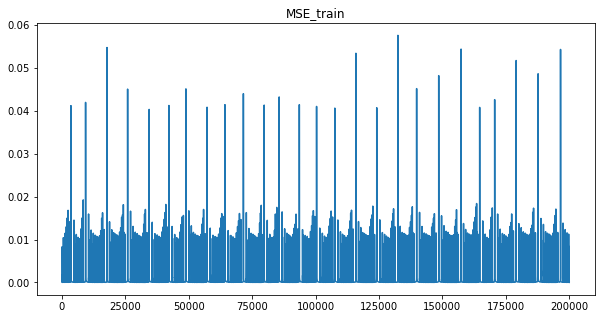

In [14]:
plt_mse(mse_train, title='MSE_train')

In [15]:
pred_test = model.predict(df_test1_w)

6080/6080 [==============================] - 49s 8ms/step


In [16]:
mse_test1 = np.mean(np.power(flatten_2(df_test1_w) - flatten_2(pred_test), 2), axis=1)

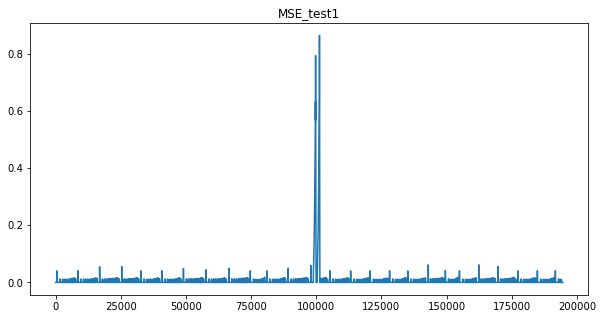

In [17]:
plt_mse(mse_test1, title='MSE_test1')

### OCSVM

In [18]:
import math
from sklearn import svm

In [19]:
def change_label(label):
    arr = []
    for i in label: 
        if i == -1:
            arr.append(1)
        else:
            arr.append(0)
    return arr

def print_distrib(arr):
    labels = {}
    for i in arr:
        if i in labels.keys():
            labels[i] += 1
        else:
            labels[i] = 1
    print(labels)

#### В OCSVM будем передавать многомерный вектор с ошибкой реконтрукции

In [20]:
e=(df_train_w - pred_train)**2
nsamples, nx, ny = e.shape
d2_e = e.reshape((nsamples,nx*ny)) # --- X_train

e_t=(df_test1_w - pred_test)**2
nsamples, nx, ny = e_t.shape
d2_e_t = e_t.reshape((nsamples,nx*ny)) # ---  X_test


In [21]:
clf_1 = svm.OneClassSVM(nu=0.000081, kernel="rbf", gamma=0.01)

print('FIT....')
clf_1.fit(d2_e)
print('FIT DONE')
print('PREDICT...')
y_scores_1 = clf_1.predict(d2_e_t)
print('PREDICT DONE')

anomaly1 = change_label(y_scores_1)
print_distrib(anomaly1)
print(f1_score(y1[:len(y1)-12].values, anomaly1))
print(classification_report(y1[:len(y1)-12].values, anomaly1))

FIT....
FIT DONE
PREDICT...
PREDICT DONE
{0: 192554, 1: 1992}
0.6523172387046733
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    191381
         1.0       0.84      0.53      0.65      3165

    accuracy                           0.99    194546
   macro avg       0.92      0.76      0.82    194546
weighted avg       0.99      0.99      0.99    194546



#### Подбираем гиперпраметры OCSVM

In [ ]:
from time import time

num = 0
best_f1 = [0,0]
all_models = {}


for gamma in np.arange(1., 2., 0.1): # gamma    
    for nu in np.arange(0.00005, 0.0002, 0.00001): # NU
        start = time()
        print(num, " -- model FIT... -- nu:", nu, "| kernel: rbf", '| gamma:', gamma)
        clf_1 = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
        clf_1.fit(d2_e)
        print('FIT DONE')
        print('PREDICT...')
        y_scores_1 = clf_1.predict(d2_e_t)
        print('PREDICT DONE')

        anomaly1 = change_label(y_scores_1)
        print_distrib(anomaly1)

        f1 = f1_score(y1[:len(y1)-12].values, anomaly1)


        if f1 > best_f1[1]:
            best_f1[0] = num
            best_f1[1] = f1
            all_models[num] = {'nu':nu, 'kernel':'rbf', 'gamma':gamma}
        num+=1

        print('-- F1: ', f1, ' -- TIME:', (time() - start))
        print('------------------------------------')


In [ ]:
print(best_f1[1])
print(all_models[best_f1[0]])

#### Получаем скор на всех аномальных датасетах

In [22]:
datasets = []

import os
for root, dirs, files in os.walk("datasets/GHL"):  
    for filename in files:
        datasets.append(str(filename))

In [23]:
datasets = datasets[:-1]

In [24]:
def get_score(data, model_nn, model_ocsvm, treshold):
    path = 'datasets/GHL/' + data
    
    # подгтовка данных
    data_df = pd.read_csv(path)[10000:]
    y = data_df['ATTACK']
    data_df_ = data_df[all_cols]
    data_df_w = preprocessing(data_df_, window_size=12)
    
    # получаем mse     
    pred = model_nn.predict(data_df_w)
    
    e_t=(data_df_w - pred)**2
    nsamples, nx, ny = e_t.shape
    d2_e_t = e_t.reshape((nsamples,nx*ny))
    
    # Порог
    mse = np.mean(np.power(flatten_2(data_df_w) - flatten_2(pred), 2), axis=1)
    anomaly_treshold = []
    for i in mse:
        if i > treshold:
            anomaly_treshold.append(1.)
        else: anomaly_treshold.append(0.)
    f1_treshold = f1_score(y[:len(y)-12].values, anomaly_treshold)
    
    # классифицируем
#     mse_rs = np.reshape(mse, (mse.shape[0], 1))
    y_scores = model_ocsvm.predict(d2_e_t)
    anomaly = change_label(y_scores)
    f1_ocsvm = f1_score(y[:len(y)-12].values, anomaly)
    return f1_treshold, f1_ocsvm, mse


In [79]:
from time import time

In [80]:
treshold = max(mse_train)

all_scores = {}
all_treshold_scores = {}
all_mse = {}

for i in range(len(datasets)):
    start = time()
    f1_treshold, f1_ocsvm, mse = get_score(datasets[i], model, clf_1, treshold)
    
    all_treshold_scores[i+1] = f1_treshold
    all_scores[i+1] = f1_ocsvm
    all_mse[i+1] = mse
    
    print(i+1, 'DATA | F1_treshold --', round(f1_treshold, 4), '| F1_ocsvm --', round(f1_ocsvm, 4))
    print(time()-start)
    print('--------------')
    

6080/6080 [==============================] - 60s 10ms/step
1 DATA | F1_treshold -- 0.0064 | F1_ocsvm -- 0.0071
71.00728273391724
--------------
6079/6079 [==============================] - 56s 9ms/step
2 DATA | F1_treshold -- 0.1751 | F1_ocsvm -- 0.1531
63.25466775894165
--------------
6080/6080 [==============================] - 60s 10ms/step
3 DATA | F1_treshold -- 0.1814 | F1_ocsvm -- 0.1683
68.6653482913971
--------------
6078/6078 [==============================] - 62s 10ms/step
4 DATA | F1_treshold -- 0.1781 | F1_ocsvm -- 0.1536
69.09205532073975
--------------
6079/6079 [==============================] - 58s 10ms/step
5 DATA | F1_treshold -- 0.1402 | F1_ocsvm -- 0.0481
62.80219793319702
--------------
6083/6083 [==============================] - 54s 9ms/step
6 DATA | F1_treshold -- 0.1749 | F1_ocsvm -- 0.1344
60.76731586456299
--------------
6085/6085 [==============================] - 56s 9ms/step
7 DATA | F1_treshold -- 0.0079 | F1_ocsvm -- 0.006
61.93807291984558
------------

In [81]:
np.mean(list(all_scores.values())[24:])

0.6788753005286097

In [82]:
np.mean(list(all_treshold_scores.values())[24:])

0.6322432085649329

#### Среднее значение метрики F1_score на 24 последних датасетах - 0.6788 -- OCSVM
#### Среднее значение метрики F1_score на 24 последних датасетах - 0.6322 -- Treshold

#### Визуализация скора на всех датасетах

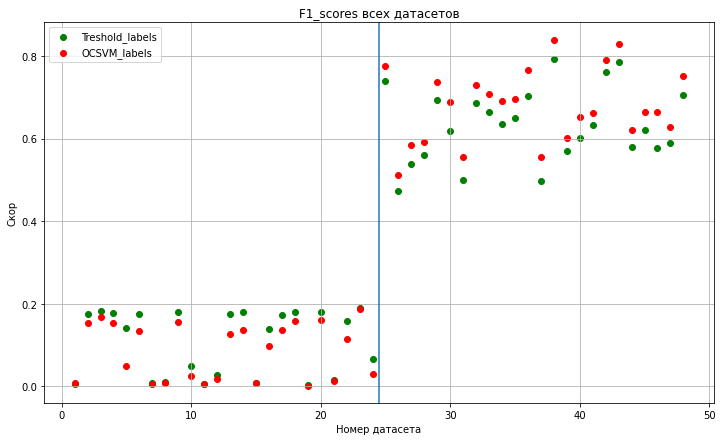

In [83]:
plt.figure(figsize=(12, 7))
plt.scatter(all_treshold_scores.keys(), all_treshold_scores.values(), color="g", label='Treshold_labels')
plt.scatter(all_scores.keys(), all_scores.values(), color="r", label='OCSVM_labels')
plt.axvline(24.5)
plt.title('F1_scores всех датасетов')
plt.xlabel('Номер датасета')
plt.ylabel('Скор')
plt.legend(loc='upper left')
plt.grid()
plt.grid(which='minor')

#### Визулизация реальных и предсказанных аномалий на рандомном датасете

In [25]:
path = 'datasets/GHL/' + datasets[-1]
# подгтовка данных
data_df = pd.read_csv(path)[10000:]
y = data_df['ATTACK']
data_df_ = data_df[all_cols]
data_df_w = preprocessing(data_df_, window_size=12)

# получаем mse     
pred = model.predict(data_df_w)
mse = np.mean(np.power(flatten_2(data_df_w) - flatten_2(pred), 2), axis=1)

# Подготавливаем данные для OCSVM
e_t=(data_df_w - pred)**2
nsamples, nx, ny = e_t.shape
d2_e_t = e_t.reshape((nsamples,nx*ny))

# классифицируем
y_scores = clf_1.predict(d2_e_t)
anomaly = change_label(y_scores)
f1 = f1_score(y[:len(y)-12], anomaly)
print(f1)

6082/6082 [==============================] - 49s 8ms/step
0.7517903397836354


In [26]:
treshold = max(mse_train)

anom1 = []

for i in mse:
    if i > treshold:
        anom1.append(1.)
    else: anom1.append(0.)

In [45]:
f1_ts = round(f1_score(y[:len(y)-12], anom1), 4)

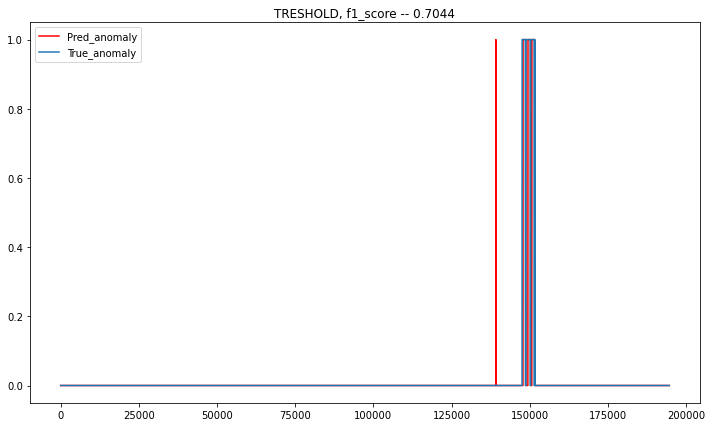

In [52]:
title = 'TRESHOLD, f1_score -- ' +str(f1_ts)

plt.figure(figsize=(12,7))
plt.title(title)
plt.plot(anom1, color='r', label='Pred_anomaly')
plt.plot(y[:len(y)-12].values, label='True_anomaly')
plt.legend(loc='upper left')


Text(0.5, 1.0, 'OCSVM, f1_score -- 0.7518')

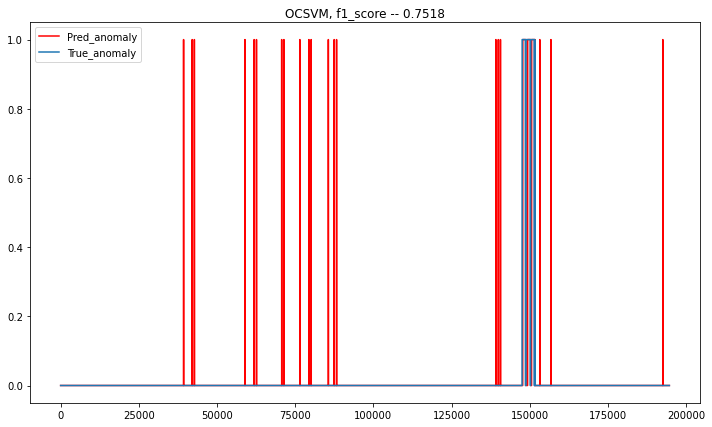

In [54]:
title = 'OCSVM, f1_score -- ' +str(round(f1,4))

plt.figure(figsize=(12,7))
plt.plot(anomaly, color='r', label='Pred_anomaly')
plt.plot(y[:len(y)-12].values, label='True_anomaly')
plt.legend(loc='upper left')
plt.title(title)

### CPD, метрика MAE

Для нахождения метрики MAE нам неободимы Реальные метки аномалий, Предсказанные метки и столбец времени Time

In [75]:
pred_a = [int(i) for i in anomaly] # -- Создаем списки предсказанных меток и реальных меток
true_a = [int(i) for i in y[:len(y)-12].values]

In [31]:
df = pd.DataFrame(data={'time':np.arange(len(pred_a)), 'true':true_a, 'pred':pred_a}) 
# Создаем датафрейм, куда в столбец Time просто передаем список чисел от 0 до длины Pred_a (или True_a, разницы нет)

In [32]:
# Меняем в столбце Time числа на временной тип данных

from datetime import datetime

for i in df["time"]:
    df["time"][i] = datetime.fromtimestamp(i).strftime("%Y-%m-%d %I:%M:%S")
    
df['time'] = df['time'].astype('datetime64[ns]')

In [34]:
# Импортируем Катин файл с классом Metrics
from metrics import Metrics

In [76]:
# Беру только часть данных 
current_df = df[140000:160000].reset_index()

In [77]:
# Инициализируем экземпляр класса
metrics = Metrics(current_df['true'], current_df['pred'], current_df['time'], '1sec')

In [78]:
# Вызов метода
metrics.maerror()

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 9782.51it/s]

MAE: 0:00:16.951940


datetime.timedelta(seconds=16, microseconds=951940)

### ROC AUC

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc

In [88]:
desicion_func = abs(clf_1.decision_function(d2_e_t))

In [99]:
fpr,tpr,thresholds = roc_curve(y[:len(y)-12].values, desicion_func)

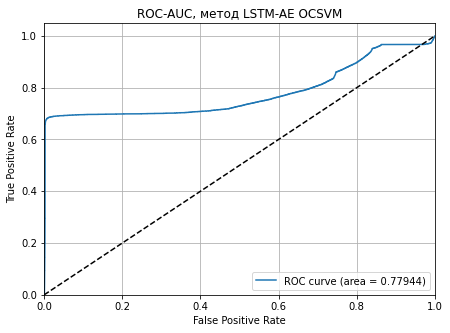

In [100]:
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC, метод LSTM-AE OCSVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()